# Neighborhood Modeling

TBD

# Summary

TBD

In [2]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from scipy.fft import fft, fftfreq, fftshift
import scipy
import itertools

# Set style
plt.style.use('seaborn')

In [3]:
# Import util file

from util import dickey_fuller, process_neighborhood, report_metrics, plot_results

In [4]:
# Modeling

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima.stationarity import ADFTest

from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [5]:
df_citibike = pd.read_csv('./clean_data/final_clean_ridership.csv', low_memory=False)

In [6]:
# Import clean dataset

df_citibike = pd.read_csv('./clean_data/final_clean_ridership.csv', low_memory=False)

# Convert starttime to date and set as index

df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'])

df_citibike.set_index('starttime', inplace=True)

# Create the daily file

daily_ridership = df_citibike[['ride_count']].resample('1D').sum()

# Filter for only data prior to 5/1/2021 (logic for this is in the EDA notebook)
# daily_ridership = daily_ridership[daily_ridership.index < '2021-06-01']

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

In [7]:
# Read in clean neighborhood list and convert to list

temp_df = pd.read_csv('./clean_data/neighborhood_list.csv', low_memory=False)

neighborhood_list = list(temp_df.iloc[:,1])

In [8]:
# Process each of the DFs in the neighborhood list

df_dict = {}

for neighborhood in neighborhood_list:
    df = process_neighborhood(df_citibike, neighborhood)
    df_dict[neighborhood] = df

In [9]:
# Resample for weekly given better performance of overall model on weekly data

for neighborhood, df in df_dict.items():
    df_dict[neighborhood] = df[['ride_count']].resample('W-SAT').sum()

In [10]:
# Add future column to define train and test periods

test_start = '2020-03-01'

for neighborhood, df in df_dict.items():
    
    df['future'] = (df.index >= '2020-03-01').astype('int')
    
    df_dict[neighborhood] = df

In [11]:
# Create a dataframe to store neighborhood by neighborhood results

df_results = pd.DataFrame(index=neighborhood_list, columns=['model', 'order', 'seasonal_order',
                                                            'explained_variance', 'MAE', 'MSE', 'R2',
                                                            '2021_actual', '2021_predicted', 'delta', 
                                                            'requires_log'])

In [12]:
# Create another dataframe to store the predictions from each model

df_preds = pd.DataFrame(index=df_dict['Clinton'][df_dict['Clinton'].index >= test_start].index, 
                        columns=neighborhood_list)

In [13]:
# Pull a sample dataframe

df_clinton = df_dict['Clinton']

In [14]:
# Test for whether I need to log transform ridership column. This test will be based on whether there has been
# an upward trend in the data. Threshold will be set at 50% growth requires logging.

for neighborhood, df in df_dict.items():
    
    # Define growth threshold
    threshold = 0.5
    
    # Decompose time series
    decomposed_ts = decompose(df_clinton['ride_count'].values, 'multiplicative', m=52)
    
    # Look at trend, specifically, and remove nulls
    trend = [trend for trend in decomposed_ts.trend if trend > 0]
    
    # Calculate growth rate (take last and first points)
    growth = (trend[-1] - trend[0]) / trend[0]
    
    # Append True or False to the df_results
    if growth >= threshold:
        df_results.loc[neighborhood, 'requires_log'] = True
        df['ride_count_log'] = df['ride_count'].apply(lambda x: np.log(x))
        df_dict[neighborhood] = df
    else:
        df_results.loc[neighborhood, 'requires_log'] = False

## First Arima Model

- Model will use tuned inputs from the overall model

In [15]:
def run_model(results, df_preds_, neighborhood, ts, order, seasonal_order, logged):
    
    '''
    Docstring here. This will be a long one.
    '''
    
    train = ts[ts['future'] == 0]
    test = ts[ts['future'] == 1]

    
    if logged:
        sari_model = SARIMAX(train['ride_count_log'], order=order, seasonal_order=seasonal_order).fit(maxiter=1000)
    else:
        sari_model = SARIMAX(train['ride_count'], order=order, seasonal_order=seasonal_order).fit(maxiter=1000)
    
    # Add preds to predictions DataFrame
    preds = sari_model.forecast(steps = len(test))
    if logged:
        df_preds_.loc[:,neighborhood] = np.exp(preds)
    else:
        df_preds_.loc[:,neighborhood] = preds
    
    # Retrieve metrics
    if logged:
        model_results = report_metrics(test['ride_count'], np.exp(preds), False)
    else:
        model_results = report_metrics(test['ride_count'], preds, False)
    
    # Calculate actual vs. predicted rides for 2021
    actual_rides_2021 = ts[ts.index > '12/31/2020']['ride_count'].sum()
    pred_rides_2021 = df_preds[df_preds.index > '12/31/2020'][neighborhood].sum()
    
    ride_delta = np.abs(pred_rides_2021 - actual_rides_2021)
    
    # Add results to results dataframe
    results.loc[neighborhood, 'model'] = sari_model
    results.loc[neighborhood, 'order'] = order
    results.loc[neighborhood, 'seasonal_order'] = seasonal_order
    results.loc[neighborhood, 'explained_variance'] = model_results[0]
    results.loc[neighborhood, 'MAE'] = model_results[1]
    results.loc[neighborhood, 'MSE'] = model_results[2]
    results.loc[neighborhood, 'R2'] = model_results[3]
    results.loc[neighborhood, '2021_actual'] = actual_rides_2021
    results.loc[neighborhood, '2021_predicted'] = pred_rides_2021
    results.loc[neighborhood, 'delta'] = ride_delta
    
    return results, df_preds_

In [16]:
# Test to see if the function works correctly

df_results, df_preds = run_model(df_results, df_preds, 'Clinton', df_dict['Clinton'], (3, 1, 1), (1, 1, 0, 52), 
                                 df_results.loc['Clinton', 'requires_log'])

In [17]:
# Run the baseline model for every neighborhood

for neighborhood, df in df_dict.items():
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, df, (3, 1, 1), (1, 1, 0, 52), 
                                     df_results.loc[neighborhood, 'requires_log'])

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
df_results

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log
Clinton,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.67076,3423.9,4516.68,0.387657,706840,808040,101200,True
SoHo-TriBeCa-Civic Center-Little Italy,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.647587,9118.48,11192.8,0.0741634,1266160,1.5628e+06,296644,True
Chinatown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.658706,6077.38,6897.99,-0.492449,676262,942694,266432,True
Fort Greene,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.64592,2071.1,2566.48,0.0143448,309627,385165,75537.6,True
Hudson Yards-Chelsea-Flatiron-Union Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.613747,21640.1,24396.9,-0.745587,2190634,3.07805e+06,887411,True
Bedford,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.629812,849.547,1089.25,0.616875,207296,227169,19873.5,True
West Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.701461,14849.2,16917.2,-0.242599,1571664,2.17088e+06,599212,True
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.512278,18516.5,20484.4,-1.5725,1562113,2.30708e+06,744965,True
Brooklyn Heights-Cobble Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.471981,1264.62,1562.4,0.462565,247070,219515,27555.2,True
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.654683,3651.44,4423.79,0.0659792,537851,663962,126111,True


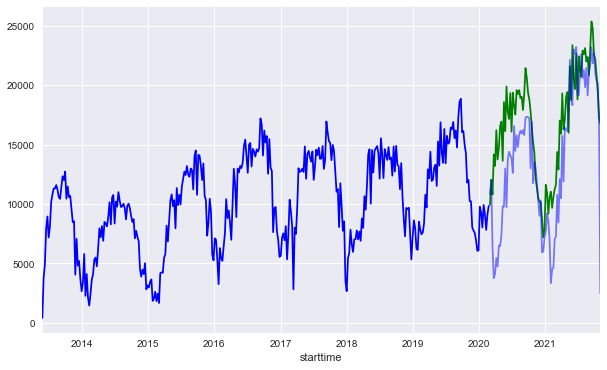

In [19]:
# Test plotting functionality

plot_results(df_dict['Clinton'], 
             df_preds.loc[:,'Clinton'], False)

## ARIMA tuning

- I will attempt to tune models with an R2 below 0.25

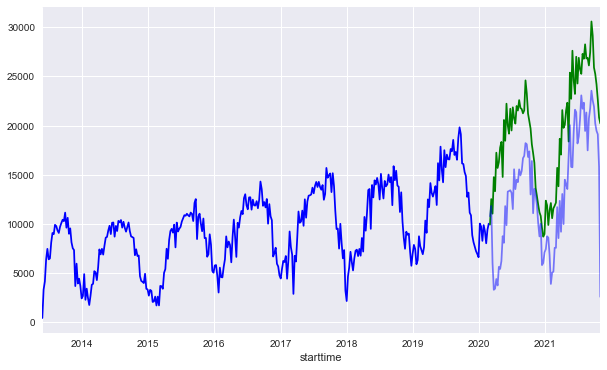

In [20]:
# Basline model plot

plot_results(df_dict['Chinatown'], 
             df_preds.loc[:,'Chinatown'], False)

In [21]:
r2_threshold = 0.25

df_tune = df_results[df_results['R2'] <= r2_threshold]

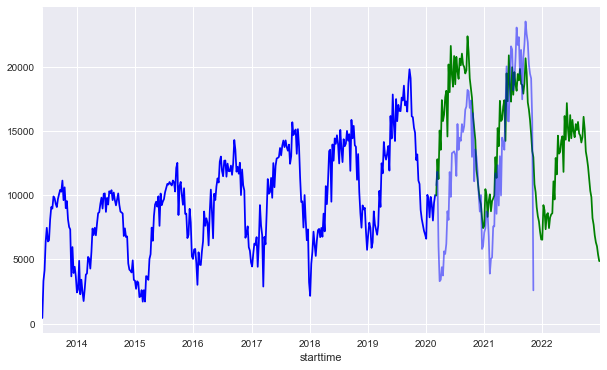

In [22]:
# Updating differencing term to 2 eliminates the upward trend in the data. Not suitable for outer year forecasting.

chinatown = df_dict['Chinatown']

chinatown_train = chinatown[chinatown['future'] == 0]
chinatown_test = chinatown[chinatown['future'] == 1]

sari_model = SARIMAX(chinatown_train['ride_count_log'], order=(1, 2, 1), seasonal_order=(1, 1, 0, 52)).fit()

plot_results(chinatown, sari_model.forecast(steps = len(chinatown_test) + 60), True)

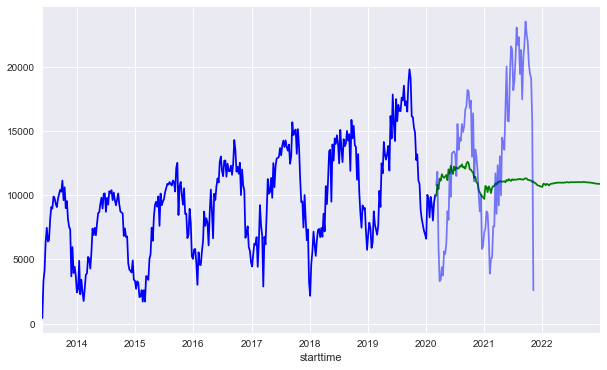

In [23]:
# Updating differencing term to 2 eliminates the upward trend in the data. Not suitable for outer year forecasting.

chinatown = df_dict['Chinatown']

chinatown_train = chinatown[chinatown['future'] == 0]
chinatown_test = chinatown[chinatown['future'] == 1]

sari_model = SARIMAX(chinatown_train['ride_count_log'], order=(3, 1, 1), seasonal_order=(1, 0, 0, 52)).fit()

plot_results(chinatown, sari_model.forecast(steps = len(chinatown_test) + 60), True)

There doesn't appear to be another combination of ordering that results in the model performing better. The key will be ensuring it doens't overshoot after COVID.

## Adjust Train / Test split times

- For the neighborhoods that haven't experienced a faster post-COVID recovery in bike ridership, try adjusting the train / test split to see if incorporating COVID data helps performance

Repeat cleaning steps from up above, but just adjust the "future" cutoff

In [24]:
# Process each of the DFs in the neighborhood list

df_dict_covid = {}

for neighborhood in neighborhood_list:
    df = process_neighborhood(df_citibike, neighborhood)
    df_dict_covid[neighborhood] = df

In [25]:
# Resample for weekly given better performance of overall model on weekly data

for neighborhood, df in df_dict_covid.items():
    df_dict_covid[neighborhood] = df[['ride_count']].resample('W-SAT').sum()

In [26]:
# Add future column to define train and test periods

test_start_covid = '2020-11-01'

for neighborhood, df in df_dict_covid.items():
    
    df['future'] = (df.index >= test_start_covid).astype('int')
    
    df_dict_covid[neighborhood] = df

In [27]:
# Create a dataframe to store neighborhood by neighborhood results

df_results_covid = pd.DataFrame(index=neighborhood_list, columns=['model', 'order', 'seasonal_order',
                                                                  'explained_variance', 'MAE', 'MSE', 'R2',
                                                                  '2021_actual', '2021_predicted', 'delta', 
                                                                  'requires_log'])

In [28]:
# Create another dataframe to store the predictions from each model

df_preds_covid = pd.DataFrame(index=df_dict_covid['Clinton'][df_dict_covid['Clinton'].index >= test_start].index, 
                              columns=neighborhood_list)

In [29]:
# I know from before that I will want to log transform the columns. Skipping the part where I test the trend

for neighborhood, df in df_dict_covid.items():

    df_results_covid.loc[neighborhood, 'requires_log'] = True
    df['ride_count_log'] = df['ride_count'].apply(lambda x: np.log(x))
    df_dict_covid[neighborhood] = df

In [69]:
# Run models for each neighborhood. Use parameters that performed best on overall model.

for neighborhood, df in df_dict_covid.items():
    df_results_covid, df_preds_covid = run_model(df_results_covid, df_preds_covid, neighborhood, df, 
                                                 (3, 1, 1), (1, 0, 1, 52), 
                                                 df_results.loc[neighborhood, 'requires_log'])

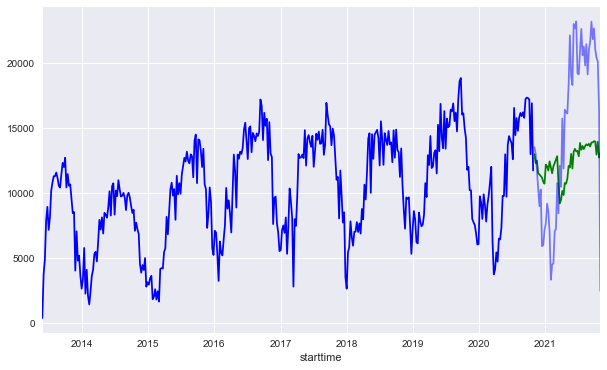

In [71]:
plot_results(df_dict_covid['Clinton'], 
             df_preds_covid.loc[:,'Clinton'], False)

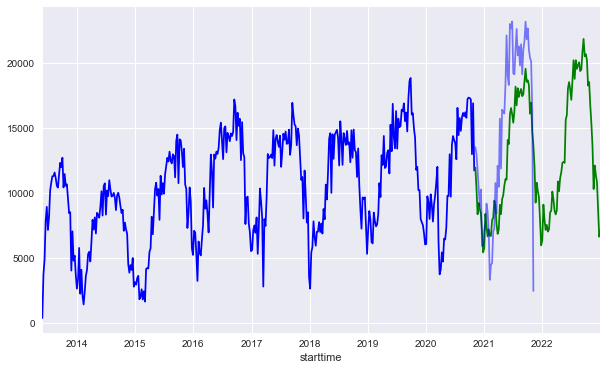

In [99]:
# Try testing various model combinations on Clinton

df_clinton_covid = df_dict_covid['Clinton']

clinton_train = df_clinton_covid[df_clinton_covid['future'] == 0]
clinton_test = df_clinton_covid[df_clinton_covid['future'] == 1]

clinton_model = SARIMAX(clinton_train['ride_count_log'], order=(3, 1, 1), seasonal_order=(1, 1, 1, 52)).fit()

plot_results(df_clinton_covid, clinton_model.forecast(steps = len(clinton_test) + 60), True)

In [90]:
sari_model.aic

70.4265119426348

In [97]:
# Grid search on Clinton

p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(clinton_train['ride_count_log'], 
                        order=param,
                        seasonal_order=param_seasonal).fit(maxiter=1000)
            results = mod.aic
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results))
        except: 
            print('Model Error!')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:164.29515040117934
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:108.90099111115902
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:145.5055564338819
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:105.53954457876124
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:117.23834171915581
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:70.24533629145078
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:96.65018166349662
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:69.11083065783211
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:126.90111189732221
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:72.88487084901432
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:106.17045216071108
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:71.52426412993665
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:117.8910890238876
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:72.12472395839784
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:97.9464528965915
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:71.00364737328869


Lowest AIC actually doesn't have an AR term. Will sense check this result

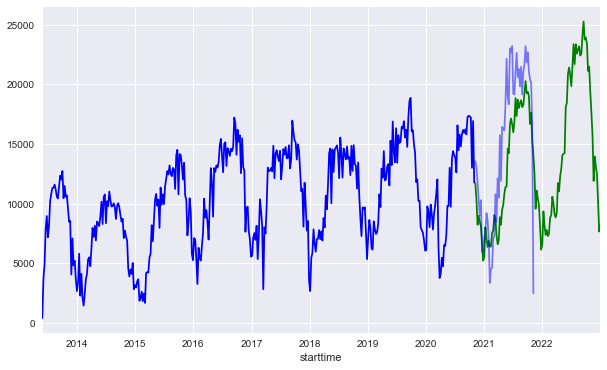

In [98]:
# Test best ARIMA from grid search on Clinton

df_clinton_covid = df_dict_covid['Clinton']

clinton_train = df_clinton_covid[df_clinton_covid['future'] == 0]
clinton_test = df_clinton_covid[df_clinton_covid['future'] == 1]

clinton_model2 = SARIMAX(clinton_train['ride_count_log'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 52)).fit()

plot_results(df_clinton_covid, clinton_model2.forecast(steps = len(clinton_test) + 60), True)

Actually a bit better without the AR Term. Will run a grid search on all the neighborhoods to test.

### Neighborhood grid search

In [1]:
df_grid_search = pd.DataFrame(index=neighborhood_list, columns=['order', 's_order', 'aic'])

NameError: name 'pd' is not defined

In [107]:
def neighborhood_grid_search(pdq, seasonal_pdq, neighborhood, df, df_grid_search):
    
    # Set AIC to some high number to ensure at least one model is below
    best_aic = 10000000

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try: 
                mod = SARIMAX(df['ride_count_log'], order=param, seasonal_order=param_seasonal).fit(maxiter=1000)
                
                if mod.aic < best_aic:
                    best_aic = mod.aic
                    best_order = param
                    best_s_order = param_seasonal
                    df_grid_search.loc[:,neighborhood] = [best_order, best_s_oder, best_aic]
            except: 
                continue

In [ ]:
for neighborhood, df in df_dict_covid.items():
    neighborhood_grid_search(pdq, seasonal_pdq, neighborhood, df, df_grid_search)

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Incorporate exogenous COVID variables

- For the neighborhood files, I need to control for lower ridership due to COVID.
- Re-do the train / test split with some COVID data to train the index
- Incorporate the weekly COVID tracker (backfilled with values of 100 for each period prior to 2020)

In [24]:
# Read in the COVID data

covid_df = pd.read_csv('./covid_data/data-uIenF.csv')

In [25]:
# Preview the head of the data

covid_df.head()

,Date,Covid-19 Hospitalizations Index,Unemployment Claims Index,Home Sales Index,Rental Inventory Index,Subway Mobility Index,Restaurant Reservations Index
0,2020-01-04,16.7,16.8,14.6,16.1,15.8,16.7
1,2020-01-11,16.7,15.5,19.4,16.1,16.9,16.7
2,2020-01-18,16.7,15.5,19.0,16.2,16.7,16.7
3,2020-01-25,16.7,16.2,17.9,16.6,17.3,16.7
4,2020-02-01,16.7,18.4,18.2,16.3,17.2,16.7


In [26]:
# Convert the axis to datetime and create a "overall_index" column

covid_df['Date'] = pd.to_datetime(covid_df['Date'])

covid_df.set_index('Date', inplace=True)

covid_df['overall_index'] = covid_df.sum(axis=1)

In [27]:
# Sense check the results

covid_df.head(2)

,Covid-19 Hospitalizations Index,Unemployment Claims Index,Home Sales Index,Rental Inventory Index,Subway Mobility Index,Restaurant Reservations Index,overall_index
Date,,,,,,,
2020-01-04,16.7,16.8,14.6,16.1,15.8,16.7,96.7
2020-01-11,16.7,15.5,19.4,16.1,16.9,16.7,101.3


In [28]:
# Need to index on 'W-SAT' for the dates to line up

weekly_ridership = df_citibike.resample('W-SAT').sum()

weekly_ridership[weekly_ridership.index > '12/31/2019'].head()

,lat,long,ride_count,year
starttime,,,,
2020-01-04,241980.497558,-439433.137573,182595,11998305
2020-01-11,247560.331465,-449564.677521,305944,12277560
2020-01-18,247192.471613,-448899.513908,293624,12259380
2020-01-25,247110.350304,-448751.027035,248305,12255340
2020-02-01,247517.860672,-449490.762316,307286,12275540


In [52]:
# Test incorporating the COVID data into each of the neighborhood dataframes

df_clinton[df_clinton.index > '12/31/2019']

,ride_count,future,ride_count_log
starttime,,,
2020-01-04,6092,0,8.714732
2020-01-11,9772,0,9.187276
2020-01-18,9292,0,9.136909
2020-01-25,8024,0,8.990192
2020-02-01,9922,0,9.202510
...,...,...,...
2021-10-09,21060,1,9.955131
2021-10-16,20418,1,9.924172
2021-10-23,20144,1,9.910662


### Scratchwork below (attempting to systematically identify seasonality)

In [31]:
# df_clinton = df_dict['Clinton']

In [32]:
# df_clinton['ride_count'].plot();

In [33]:
# df_clinton.head(1)

In [34]:
# df_clinton.plot();

In [35]:
# df_clinton.drop('fft', axis=1, inplace=True)

In [36]:
# df_clinton['future'] = (df_clinton.index >= '2020-03-31').astype('int')

# df_clinton.insert(0, 't', range(len(df_clinton)))

In [37]:
# df_clinton.tail()

In [38]:
# X_train = df_clinton.loc[df_clinton.future == 0, 't'].values.reshape(-1, 1)
# X_test = df_clinton.loc[df_clinton.future == 1, 't'].values.reshape(-1, 1)

# # The train set is the actual value in the series
# y_train = df_clinton.loc[df_clinton.future == 0, 'ride_count'].values
# y_test = df_clinton.loc[df_clinton.future == 1, 'ride_count'].values

In [39]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_preds_lr = list(lr.predict(X_test))
# y_trend_lr = list(lr.predict(X_train))

In [40]:
# Add predictions to the dataframe

# df_clinton['preds'] = y_trend_lr + y_preds_lr
# df_clinton['resid'] = df_clinton['ride_count'] - df_clinton['preds']
# df_clinton.head()

In [41]:
# Create the Fourier transformation

# time = df_clinton['t']
# residuals = df_clinton['resid']

# fft_output = fft(residuals.values)
# power = np.abs(fft_output)
# freq = fftfreq(len(residuals))

In [42]:
# peaks = scipy.signal.find_peaks(power[freq >=0], prominence=10**4)[0]
# peak_freq = freq[peaks]
# peak_power = power[peaks]
# plt.plot(peak_freq, peak_power, 'ro');

In [43]:
# Plot results

# plt.figure(figsize=(10,6))
# plt.plot(df_clinton['ride_count'])
# plt.plot(df_clinton.loc[df_clinton.future == 0].index, y_trend_lr, color='orange')
# plt.plot(df_clinton.loc[df_clinton.future == 1].index, y_preds_lr, color='green')
# plt.show()

### Search for a systematic way to find seasonality

In [44]:
# df_clinton.head()

In [45]:
# seasonal = pd.DataFrame(decomposed_ts.seasonal, index=df_clinton.index, columns=['Seasonal Ridership'])

# seasonal

In [46]:
# for i, year in enumerate(list(seasonal.index.year.unique())):
#     if i == 2:
#         temp_df1 = seasonal[seasonal.index == year]
#         temp_df2 = seasonal[seasonal.index == year + 1]
        
#     if temp_df1['ride_count']

In [47]:
# pm.arima.nsdiffs(df_clinton['ride_count'].values, m=52)

In [48]:
# pmdarima.arima.nsdiffs()

In [49]:
# best_arima = SARIMAX(train_weekly2, order=(3, 1, 1), seasonal_order=(1, 1, 0, 52)).fit()